In [1]:
################################################
# intialize glove
################################################
# >pip install glove_python
# >wget http://www.google.com/search?q=glove+word+embeddings+download+those+dope+pre+trained+vectors
# >unzip dope_glove_shit.zip
# >cp cmps242_hw5_config.py.example cmps242_hw5_config.py
# >echo "set GLOVE_LOCATION in cmps242_hw5_config.py to one of those files"
################################################
from cmps242_hw5_config import *
import numpy as np

# config
INCLUDE_VARIANCE = False

# glove data
glove_data = dict()
max_glove_val = 0
with open(GLOVE_LOCATION, encoding='utf8') as glovein:
    for line in glovein:
        line = line.split()
        word = line[0]
        vec = [float(line[i]) for i in range(1,len(line))]
        for g in vec:
            if abs(g) > max_glove_val: max_glove_val = abs(g)
        glove_data[word] = vec
    print("Imported {} words, with max glove val {}".format(len(glove_data), max_glove_val))

glove_dict_length = len(vec)
def get_glove_vector(tokens, glove_information=glove_data, glove_vec_length=glove_dict_length):
    temp_vec = [[0.0] for _ in range(glove_vec_length)]

    for word in tokens:
        if word not in glove_information: continue
        glove_vec = glove_information[word]
        for i in range(glove_vec_length):
            temp_vec[i].append(glove_vec[i])
    
    vec = []
    for i in range(glove_vec_length):
        vec.append(np.mean(temp_vec[i]))
        if INCLUDE_VARIANCE: vec.append(np.std(temp_vec[i])) #this makes us perform worse

    return vec

Imported 1193514 words, with max glove val 6.9739


In [2]:
################################################
# file parsing functions
################################################
from nltk.tokenize import TweetTokenizer
import string, re
import collections
import numpy as np
import glove
from glove.glove_cython import fit_vectors, transform_paragraph

# definitions
HC="HillaryClinton"
DT="realDonaldTrump"
NA="none"
HANDLES = [HC,DT,NA]
HANDLE_MAP = {NA:-1, HC:0, DT:1}

# read csv file, return handles and tweets
def parse_tweet_csv(file, file_encoding="utf8"):
    # init
    handles, tweets = [], []
    
    # read file
    linenr = -1
    with open(file, encoding=file_encoding) as input:
        try:
            for line in input:
                linenr += 1
                if linenr == 0: continue
                
                # get contents
                line = line.split(",")
                if line[0] in HANDLES: #label and irst line of tweet
                    handles.append(line[0])
                    tweet = ','.join(line[1:])
                    tweets.append(tweet)
                else: #second+ line of tweet
                    tweet = tweets.pop()
                    tweet += ','.join(line)
                    tweets.append(tweet)
        except Exception as e:
            print("Exception at line {}: {}".format(linenr, e))
            raise e
    
    # sanity checks
    assert len(handles) == len(tweets)
    print("Found {} tweets in {} lines".format(len(tweets), linenr + 1))
    
    # return data
    return handles, tweets


##########################################
### coverting tweet strings to numbers ###

# coverting labels to integers
def int_labels(labels):
    return list(map(lambda x: HANDLE_MAP[x], labels))

#tokenizing
_tokenizer = TweetTokenizer()
_punctuation = set(string.punctuation)
def tokenize(tweet, lowercase=True, strip_urls=True, strip_punctuation=True):
    tokens = _tokenizer.tokenize(tweet)
    if lowercase: tokens = list(map(lambda x: x.lower(), tokens))
    if strip_urls: tokens = list(filter(lambda x: not x.startswith("http"), tokens))
    if strip_punctuation: #https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
        tokens = list(filter(lambda x: x.startswith(u'@') or x.startswith(u'#') or x not in _punctuation and not re.match(u"[^\w\d'\s$]+", x), tokens))
    return tokens


# get all tweets
def import_text(tweets):
    return [get_glove_vector(tokenize(tweet)) for tweet in tweets]

In [3]:
################################################
# get raw test data
################################################
import random

# init
TEST_RATIO = 0.1
assert TEST_RATIO > 0 and TEST_RATIO < 1

# get data
text_handles, raw_tweets = parse_tweet_csv("train.csv")
handles = int_labels(text_handles)
tweets = import_text(raw_tweets)   
data_vector_size = len(tweets[0])

### validation
for i in range(1):
    tweet = raw_tweets[random.randint(0, len(raw_tweets))]
    print(tokenize(tweet))
    print(get_glove_vector(tokenize(tweet)))
    print()
# for handle in int_labels(handles[0:7]):
#     print(handle)

Found 4743 tweets in 6251 lines
['america', 'needs', 'leadership', 'in', 'the', 'white', 'house', 'not', 'a', 'liability']
[0.14379363636363635, 0.0032391818181818151, 0.17495569999999996, 0.093365636363636373, 0.12517408181818182, 0.12194663636363635, 0.3631844545454545, -0.022450181818181824, 0.098126363636363637, -0.26408872727272725, 0.063339090909090914, -0.16446799999999998, -4.0688272727272734, 0.10241981818181821, 0.50555009090909087, -0.22288363636363639, -0.10493672727272725, 0.12781509090909088, 0.094303090909090906, 0.049515181818181819, -0.035895454545454536, -0.17864363636363637, -0.071469090909090899, 0.10648199999999998, 0.10824227272727273, 0.25315545454545457, 0.11925154545454547, 0.063975090909090912, 0.0196441090909091, 0.0084427272727272806, 0.13786818181818183, -0.17963563636363633, -0.042298327272727282, -0.21707090909090906, 0.51508518181818186, 0.28755669090909086, -0.026367781818181821, 0.30249754545454549, -0.22844952999999998, -0.14388132727272726, -0.768332

In [4]:
################################################
# split test data into train and test
################################################
import pandas as pd

LABEL = 'handle'
DATA = 'tweet_data'
LENGTH = 'length'

# we get floats from glove, so we need to convert them to integers.
# the glove floats are both positive and negative, and I'm not sure
# what the min/max are, so we normalize over that value, and then
# scale them to a particular granularity
# TODO how do we give floats to tensorflow?
# TODO what's the min/max we'll get from this glove library?

# this is so the glove output is in integer form (maybe not necessary)
FLOAT_GRANULARITY = (1 << 16)
VOCAB_SIZE = 2 * FLOAT_GRANULARITY + 1 # +/- and exclusive

# this is so we can define a range for the values
# value_max = 0
# for tweet in tweets:
#     for x in tweet:
#         if abs(x) > value_max: value_max = abs(x)
# print("Got max value of {}".format(value_max))
value_max = 10 # so we're not dependent on what the data is

# split into test and train
train_labels, train_data, test_labels, test_data = list(), list(), list(), list()
for handle, tweet in zip(handles, tweets):
#     if np.isnan(tweet[0]): continue #a row of all nan's happens with data that glove can't understand (like, all hashtags)
#     tweet = [list(map(lambda x: int(x / value_max * FLOAT_GRANULARITY + FLOAT_GRANULARITY), word)) for word in tweet]
    tweet = list(map(lambda x: int(x / value_max * FLOAT_GRANULARITY + FLOAT_GRANULARITY), tweet))
    if random.random() < TEST_RATIO:
        test_labels.append(handle)
        test_data.append(tweet)
    else:
        train_labels.append(handle)
        train_data.append(tweet)

# document and validate
print("Separated into {} train and {} test ({}%)\n".format(len(train_data), len(test_data), 
                                                         int(100.0 * len(test_data) / len(raw_tweets))))
assert len(train_labels) == len(train_data) and len(train_data) > 0
assert len(test_labels) == len(test_data) and len(test_data) > 0
assert len(test_labels) > len(tweets) * (TEST_RATIO - .05)
assert len(test_labels) < len(tweets) * (TEST_RATIO + .05) 

# save to dataframe
train = pd.DataFrame({
    LABEL: train_labels,
    DATA: train_data,
    LENGTH: [data_vector_size for _ in range(len(train_data))]
})
test = pd.DataFrame({
    LABEL: test_labels,
    DATA: test_data,
    LENGTH: [data_vector_size for _ in range(len(test_data))]
})
print(train.head())

Separated into 4322 train and 421 test (8%)

   handle  length                                         tweet_data
0       0      50  [67083, 66651, 65713, 66366, 66684, 66870, 704...
1       0      50  [66591, 68016, 66283, 65513, 64586, 65835, 683...
2       0      50  [67598, 67903, 66837, 65325, 65379, 66284, 704...
3       0      50  [67843, 69111, 66023, 67281, 65863, 66120, 682...
4       1      50  [67888, 66314, 67082, 62778, 66086, 65688, 690...


In [5]:
################################################
# initializing our tensor
#
# based off of blogpost david parks showed us:
# https://r2rt.com/recurrent-neural-networks-in-tensorflow-iii-variable-length-sequences.html
################################################
import tensorflow as tf
 
class DataIterator():
    def __init__(self, df):
        self.df = df
        self.size = len(self.df)
        self.epochs = 0
        self.shuffle()

    def shuffle(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        self.cursor = 0

    def next_batch(self, n):
        if self.cursor + n - 1 > self.size:
            self.epochs += 1
            self.shuffle()
        res = self.df.ix[self.cursor:self.cursor + n - 1]
        start_idx = self.cursor
        self.cursor += n
        # return res[DATA], res[LABEL], res[LENGTH]
        # the above line fails.  an error is thrown when tf attempts to call np.asarray on this.
        # what is different about how our data is organized compared to the blog post this came from?
        # TODO 
        data = res[DATA]
        labels = res[LABEL]
        length = res[LENGTH]
        return np.asarray([data[i] for i in range(start_idx, start_idx + len(data))]), \
               np.asarray([labels[i] for i in range(start_idx, start_idx + len(labels))]), \
               np.asarray([length[i] for i in range(start_idx, start_idx + len(length))])

# validate data iterator
d = DataIterator(test).next_batch(3)
print('Input sequences:\n', 
      "{}: \n{}\n".format(type(d[0]), d[0]), 
      "{}: \n{}\n".format(type(d[0][0]), d[0][0]), 
      "{}: \n{}\n".format(type(d[0][0][0]), d[0][0][0]), 
      end='\n\n')
print('Target values\n', 
      "{}: \n{}\n".format(type(d[1]), d[1]), 
      "{}: \n{}\n".format(type(d[1][0]), d[1][0]), 
      end='\n\n')
print('Sequence lengths\n', 
      "{}: \n{}\n".format(type(d[2]), d[2]), 
      "{}: \n{}\n".format(type(d[2][0]), d[2][0]), 
      end='\n\n')

Input sequences:
 <class 'numpy.ndarray'>: 
[[65238 67236 67903 65160 65404 66382 70329 65335 64896 61693 64953 63832
  38185 65877 65391 65533 65362 65759 63559 63627 65222 64546 65037 65957
  65845 69034 66683 66426 67024 66235 67660 65220 65056 66287 70290 67269
  66142 65217 64760 65971 61415 66596 66346 66987 67186 66745 64254 64269
  67315 66451]
 [70029 66674 67728 64646 68629 66745 69239 66520 65146 65263 67618 64263
  52351 69142 66498 63635 66369 68084 65817 66143 65092 67799 66270 63969
  64544 65862 64925 63437 66675 66259 66505 63384 65963 64627 67645 64984
  65991 65012 68394 63084 65005 64236 66555 64735 66069 65594 64956 65252
  63968 64808]
 [66041 65724 67042 63663 64809 67065 69080 67450 64856 63974 66104 65256
  38807 64996 67398 64393 64577 65475 64388 65176 66799 65080 65192 64835
  65918 68746 67057 66312 65138 64654 66289 66215 65094 66027 68735 66797
  65223 66777 65263 65341 61158 65163 67039 67178 67053 63666 66745 65018
  64793 66961]]
 <class 'numpy.ndarray

In [6]:
################################################
# initializing our tensor
#
# based off of blogpost david parks showed us:
# https://r2rt.com/recurrent-neural-networks-in-tensorflow-iii-variable-length-sequences.html
################################################
import tensorflow as tf


def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()


def build_graph(vocab_size = VOCAB_SIZE, state_size = 64, batch_size = 256, num_classes = 2):

    reset_graph()

    # Placeholders
    x = tf.placeholder(tf.int32, [batch_size, None]) # [batch_size, num_steps]
    seqlen = tf.placeholder(tf.int32, [batch_size])
    y = tf.placeholder(tf.int32, [batch_size])
    keep_prob = tf.placeholder_with_default(1.0, [])

    # Embedding layer
    embeddings = tf.get_variable('embedding_matrix', [vocab_size, state_size])
    rnn_inputs = tf.nn.embedding_lookup(embeddings, x)

    # RNN
    cell = tf.nn.rnn_cell.GRUCell(state_size)
    init_state = tf.get_variable('init_state', [1, state_size],
                                 initializer=tf.constant_initializer(0.0))
    init_state = tf.tile(init_state, [batch_size, 1])
    rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, sequence_length=seqlen,
                                                 initial_state=init_state)

    # Add dropout, as the model otherwise quickly overfits
    rnn_outputs = tf.nn.dropout(rnn_outputs, keep_prob)
    idx = tf.range(batch_size)*tf.shape(rnn_outputs)[1] + (seqlen - 1)
    # last_rnn_output = tf.gather(tf.reshape(rnn_outputs, [-1, state_size]), idx)
    # last_rnn_output = tf.gather_nd(rnn_outputs, tf.pack([tf.range(batch_size), seqlen-1], axis=1))
    last_rnn_output = tf.gather_nd(rnn_outputs, tf.stack([tf.range(batch_size), seqlen-1], axis=1))

    # Softmax layer
    with tf.variable_scope('softmax'):
        W = tf.get_variable('W', [state_size, num_classes]) # weights?
        b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0)) # bias?
    logits = tf.matmul(last_rnn_output, W) + b
    preds = tf.nn.softmax(logits)
    correct = tf.equal(tf.cast(tf.argmax(preds,1),tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

    return {
        'x': x,
        'seqlen': seqlen,
        'y': y,
        'dropout': keep_prob,
        'loss': loss,
        'ts': train_step,
        'preds': preds,
        'accuracy': accuracy
    }


def train_graph(g, batch_size = 256, num_epochs = 10, iterator = DataIterator):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        tr = iterator(train)
        te = iterator(test)

        step, accuracy = 0, 0
        tr_losses, te_losses = [], []
        current_epoch = 0
        while current_epoch < num_epochs:
            step += 1
            batch = tr.next_batch(batch_size)
            feed = {g['x']: batch[0], g['y']: batch[1], g['seqlen']: batch[2], g['dropout']: 0.6}
            accuracy_, _ = sess.run([g['accuracy'], g['ts']], feed_dict=feed)
            accuracy += accuracy_

            if tr.epochs > current_epoch:
                current_epoch += 1
                tr_losses.append(accuracy / step)
                step, accuracy = 0, 0

                #eval test set
                te_epoch = te.epochs
                while te.epochs == te_epoch:
                    step += 1
                    batch = te.next_batch(batch_size)
                    feed = {g['x']: batch[0], g['y']: batch[1], g['seqlen']: batch[2]}
                    accuracy_ = sess.run([g['accuracy']], feed_dict=feed)[0]
                    accuracy += accuracy_

                te_losses.append(accuracy / step)
                step, accuracy = 0,0
                print("Accuracy after epoch", current_epoch, " - tr:", tr_losses[-1], "- te:", te_losses[-1])

    return tr_losses, te_losses

In [7]:
################################################
# run it!
################################################

# this fails, just like us
g = build_graph()
tr_losses, te_losses = train_graph(g, num_epochs=24)

Accuracy after epoch 1  - tr: 0.502068014706 - te: 0.51171875
Accuracy after epoch 2  - tr: 0.59423828125 - te: 0.51953125
Accuracy after epoch 3  - tr: 0.666015625 - te: 0.53125
Accuracy after epoch 4  - tr: 0.81640625 - te: 0.49609375
Accuracy after epoch 5  - tr: 0.877197265625 - te: 0.453125
Accuracy after epoch 6  - tr: 0.8896484375 - te: 0.5078125
Accuracy after epoch 7  - tr: 0.862548828125 - te: 0.5
Accuracy after epoch 8  - tr: 0.880615234375 - te: 0.5703125
Accuracy after epoch 9  - tr: 0.788818359375 - te: 0.55078125
Accuracy after epoch 10  - tr: 0.814697265625 - te: 0.5078125
Accuracy after epoch 11  - tr: 0.920654296875 - te: 0.53125
Accuracy after epoch 12  - tr: 0.955810546875 - te: 0.52734375
Accuracy after epoch 13  - tr: 0.985107421875 - te: 0.5234375
Accuracy after epoch 14  - tr: 0.995361328125 - te: 0.52734375
Accuracy after epoch 15  - tr: 0.99609375 - te: 0.5390625
Accuracy after epoch 16  - tr: 0.995849609375 - te: 0.5625
Accuracy after epoch 17  - tr: 0.997558

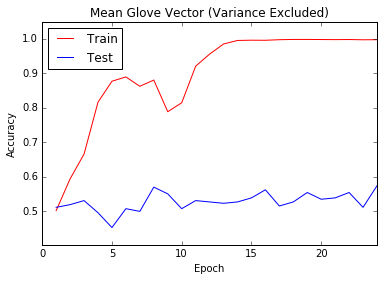

In [8]:
################################################
# plot it!
################################################

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

title = "Mean Glove Vector"
title += " (Variance Included)" if INCLUDE_VARIANCE else " (Variance Excluded)"

x_coords = [i+1 for i in range(len(tr_losses))]
tr_line, = plt.plot(x_coords, tr_losses, 'r-', label="Train")
te_line, = plt.plot(x_coords, te_losses, 'b-', label="Test")
plt.axis([0, len(tr_losses), min(min(tr_losses), min(te_losses)) - .05, 1.05])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(title)
plt.legend(handles=[tr_line, te_line], loc=2)
plt.show()

In [9]:
#TODO: we're overfitting, why?

#TODO: try something better than averaging the word vec values
# maybe we could do three-d arrays?  encode each word and pad the data

#TODO: we strip a lot away (ie punctuation, smilies) and lose other
# data to glove (#hashtags, @handles). how can we keep this?

#TODO: how do we run this on the test dataset?



##############################################################################
"""
What we tried:

glove library - broke even
    overfit and data was varied
glove "average tweet value"
    overfit and test data was varied
glove ATV with variance 
    this worked worse than ATV
twitter glove worked worse (but need better tokenizing)
"""

'\nWhat we tried:\n\nglove library - broke even\n    overfit and data was varied\nglove "average tweet value"\n    overfit and test data was varied\nglove ATV with variance \n    this worked worse than ATV\ntwitter glove worked worse (but need better tokenizing)\n'